# Importing Libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate , ShuffleSplit
from sklearn.model_selection import train_test_split,permutation_test_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
shuffle_split_cv = ShuffleSplit(n_splits = 10 ,test_size=0.2, random_state =0 )


In [8]:
features , labels = fetch_california_housing(as_frame=True , return_X_y=True)
train_features , test_features , train_labels , test_labels  = train_test_split(
    features , labels , random_state=42)

# LinearRegression Model

In [23]:
lin_reg_pipe = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("lin_reg", LinearRegression())
    ])

lin_reg_cv_results  = cross_validate(lin_reg_pipe, train_features , train_labels, 
                                     cv = shuffle_split_cv, 
                                     scoring = 'neg_mean_squared_error',
                                     n_jobs =2)
lin_reg_error = pd.Series(-lin_reg_cv_results['test_score'],
                          name="Linear Regression Error")

# Dummy Regressor

In [36]:
# Regressor that makes predictions using simple rules.
# This regressor is useful as a simple baseline to compare with other (real) regressors.

def dummy_regressor_baseline(strategy , constant_val = None , quantile_val = None):
    baseline_model_medain = DummyRegressor(strategy = strategy,
                                           constant = constant_val,
                                           quantile = quantile_val)
    baseline_model_cv_results = cross_validate(baseline_model_medain,
                                               train_features, train_labels , 
                                               cv = shuffle_split_cv , 
                                               scoring = 'neg_mean_absolute_error',
                                               n_jobs = 2)
    return pd.Series(-baseline_model_cv_results['test_score'],name="Dummy Regressor Error")
    

In [38]:
baseline_mean_cv_results_error = dummy_regressor_baseline(strategy = 'median')
baseline_median_cv_results_error = dummy_regressor_baseline(strategy = 'mean')
baseline_constant_cv_results_error = dummy_regressor_baseline(strategy = 'constant', constant_val = 2)
baseline_quantile_cv_results_error = dummy_regressor_baseline(strategy = 'quantile', quantile_val = 0.55)

In [40]:
dummy_error_df =  pd.concat([baseline_mean_cv_results_error,
                             baseline_median_cv_results_error,
                             baseline_constant_cv_results_error,
                             baseline_quantile_cv_results_error],
                            axis = 1)
dummy_error_df.columns = ['Median CV', 'Mean CV','Constant CV','Quantile CV']

Text(0.5, 1.0, 'Distribution of Testing Errors')

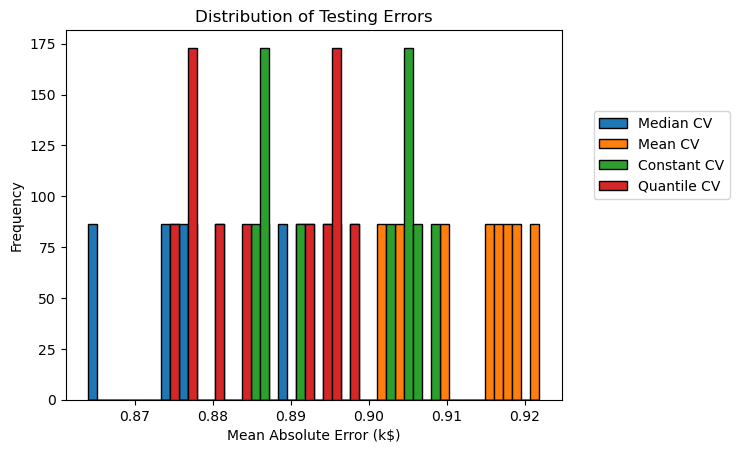

In [46]:
# bbox_to_anchor : Box that is used to position the legend in conjunction with loc

dummy_error_df.plot.hist(bins=50, density=True , edgecolor='black')
plt.legend(bbox_to_anchor = (1.05,0.8) , loc="upper left")
plt.xlabel("Mean Absolute Error (k$)")
plt.title("Distribution of Testing Errors")

## Permutation Test Score

* Evaluate the significance of a cross-validated score with permutations.
* The p-value represents the fraction of randomized data sets where the estimator performed as well or better than in the original data.
* A small p-value suggests that there is a real dependency between features and targets which has been used by the estimator to give good predictions.
* A large p-value may be due to lack of real dependency between features and targets or the estimator was not able to use the dependency to give good predictions.

In [59]:
score , permutation_score , pvalue = permutation_test_score(
    lin_reg_pipe , train_features , train_labels, 
    cv = shuffle_split_cv,
    scoring = "neg_mean_absolute_error",
    n_jobs = 2,
    n_permutations = 30)

permutation_errors = pd.Series(-permutation_score,name="Permuted Error")

In [61]:
permutation_errors

0     0.914465
1     0.916087
2     0.915011
3     0.911122
4     0.913261
5     0.914287
6     0.916943
7     0.906607
8     0.908736
9     0.915461
10    0.908469
11    0.911740
12    0.918571
13    0.914671
14    0.903967
15    0.912393
16    0.910955
17    0.917296
18    0.905294
19    0.914366
20    0.919930
21    0.916619
22    0.911047
23    0.915632
24    0.910143
25    0.915261
26    0.906802
27    0.907964
28    0.910330
29    0.915456
Name: Permuted Error, dtype: float64

# Model Comparison

In [64]:
error_df = pd.concat ([lin_reg_error,baseline_median_cv_results_error,permutation_errors],
                      axis = 1)


Text(0.5, 1.0, 'Distribution of Testing Errors')

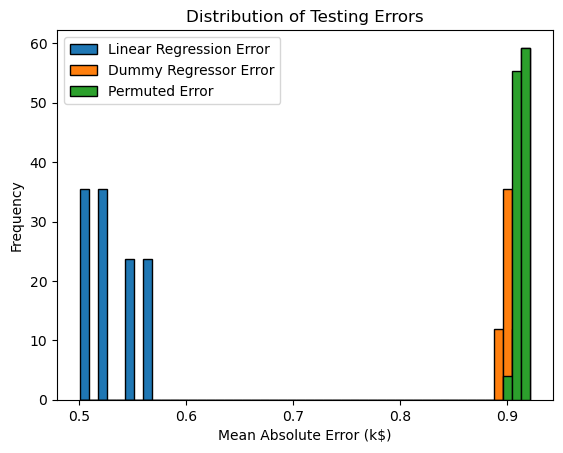

In [70]:
error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(loc="best")
plt.xlabel("Mean Absolute Error (k$)")
plt.title("Distribution of Testing Errors")